## Imports

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import matplotlib.pyplot as plt
from pathlib import Path

## Load dataset

In [27]:
path = Path().cwd()
data_file = path.parent / "Data" / "ACS.csv"

dataFrame = pd.read_csv(data_file)

dataTrain = np.asarray(dataFrame)[dataFrame['Train'] == 1,:]
dataTest = np.asarray(dataFrame)[dataFrame['Train'] == 0,:]

# split data -> some data is completely outside CV-optimization to reduce overfitting

# normal way of doing it;
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)
# But we already have indexes in the dataFrame;
X_train = dataTrain[:,:-2]
y_train = dataTrain[:,-2:-1].ravel() # Second to last row in dataframe is class

X_test = dataTest[:,:-2]
y_test = dataTest[:,-2:-1].ravel() # Second to last row in dataframe is class

seed = 42

### 5. Compute a suitable Support Vector Machine (SVM) classifier for the acute coronary syndrome data in ACS.csv. Use the matrix Xtruncated as the data matrix and y as the response variable. Find suitable parameters for a kernel SVM using 10-fold cross-validation and misclassification rate (MCR) as criterion.

In [25]:
np.hstack((y_train[:, None], X_train)).shape

(1000, 197)

(197, 197)


<Axes: >

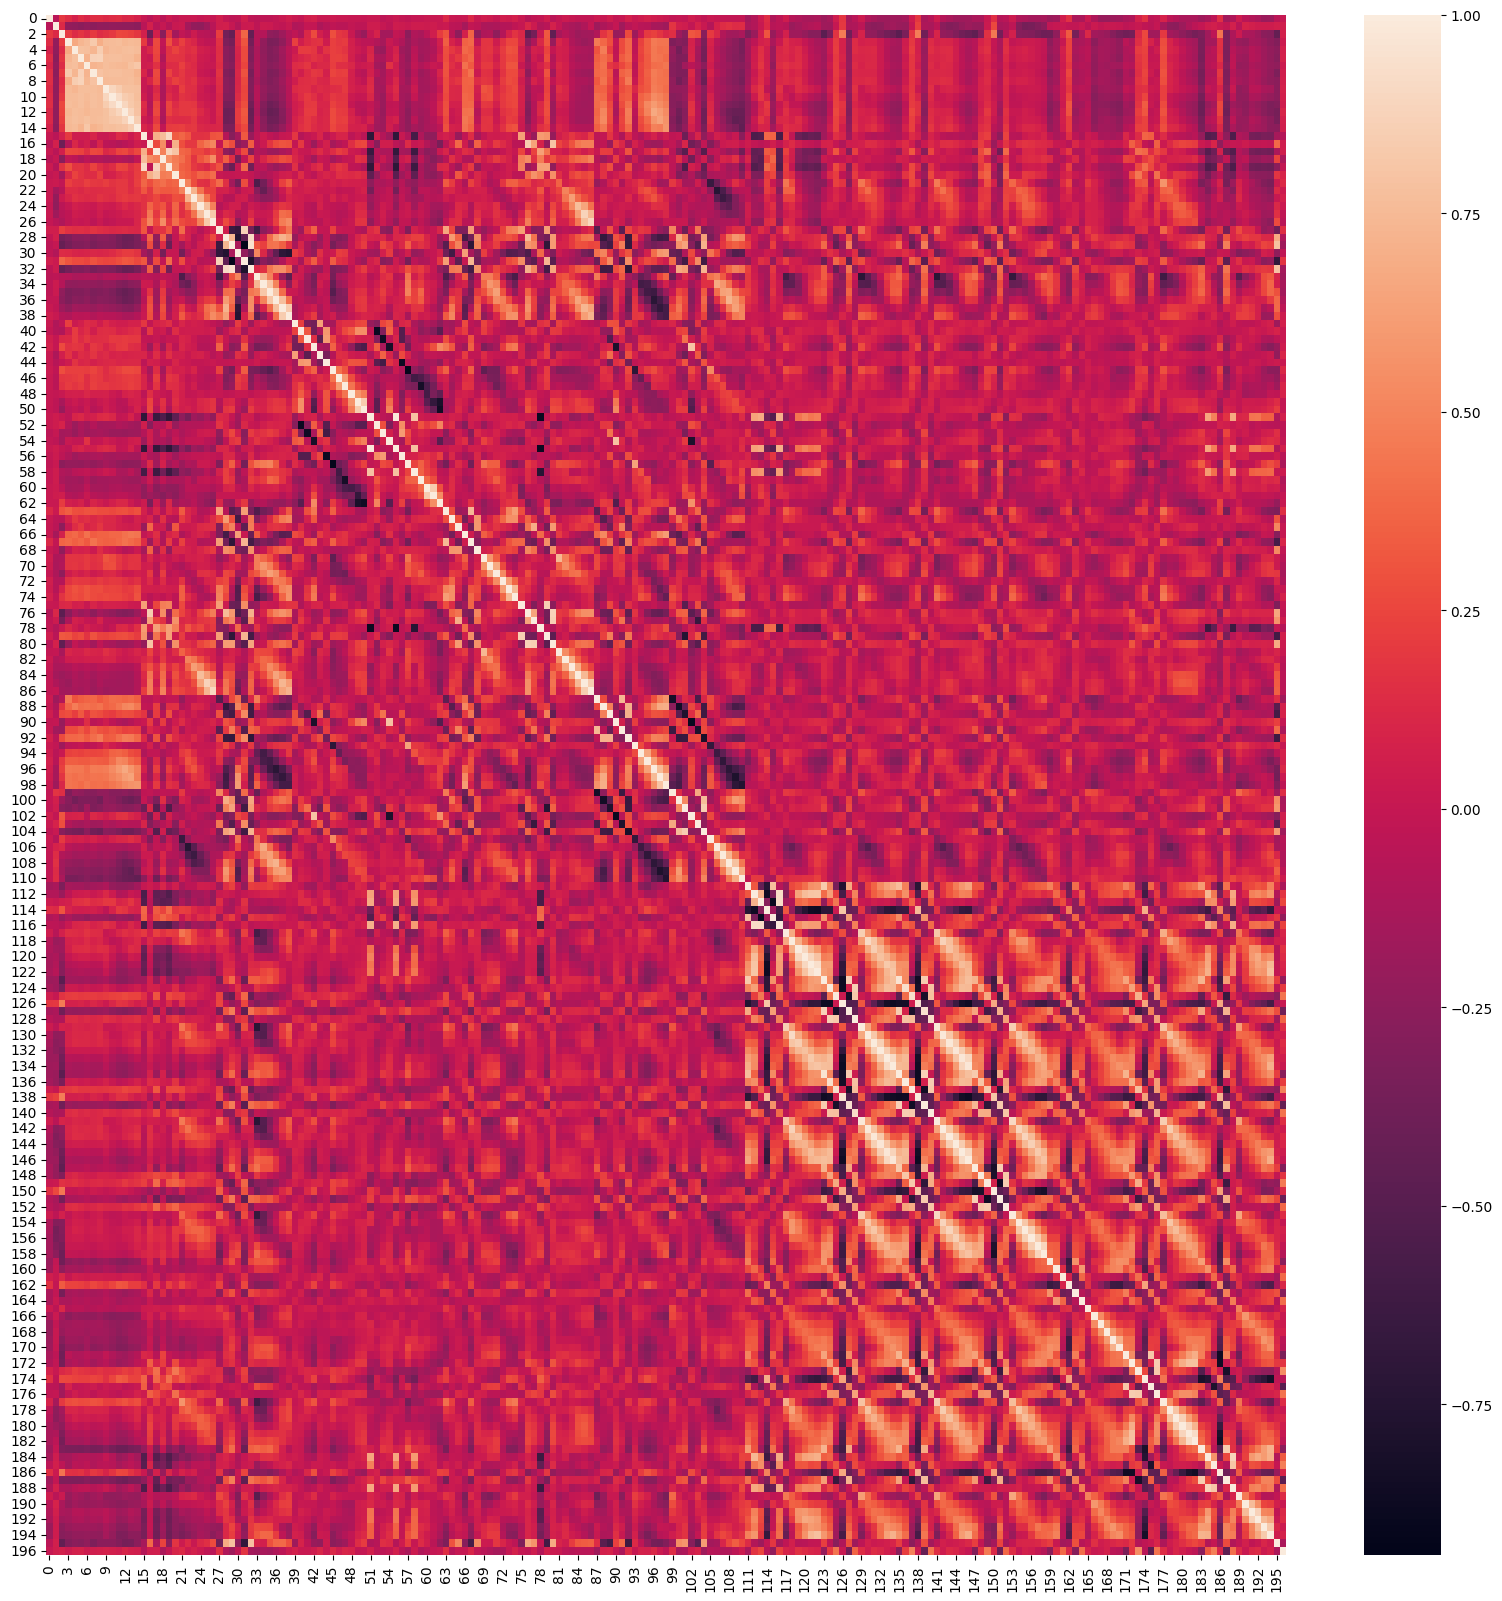

In [26]:
import seaborn as sns
corr = np.corrcoef(np.hstack((y_train[:, None], X_train)), rowvar=False)
print(corr.shape)
fig, ax = plt.subplots(1,1, figsize=(20,20))
sns.heatmap(corr, ax=ax)

In [59]:
# set up a logistic regression model for comparison.
LR_model = LogisticRegression(penalty='l1', solver='saga', max_iter=int(1e4), random_state=seed)
LR_model.fit(X_train, y_train.ravel())

y_est_test_lr = LR_model.predict(X_test)
LogModelAcc = np.abs(sum(y_est_test_lr == y_test))/len(y_test)
print(LogModelAcc)

0.9069636312376657


In [61]:
# Try to experiment with kernelType, and cVal on a SVC model from sklearn
# set up param_grid
cVal = np.logspace(-5,3)
kernelType = ['rbf', 'poly', 'sigmoid']
param_grid = {
    'C': cVal,
    'kernel': kernelType,
    'random_state': [seed]
}

# create a gridsearchCV object
clf = svm.SVC(shrinking=False)
rf_grid = GridSearchCV(estimator=svm.SVC(), param_grid=param_grid, scoring='accuracy', cv=10, verbose=2, n_jobs=-1)

# Fit the grid search model
rf_grid.fit(X_train, y_train)

print(rf_grid.best_estimator_)

Fitting 10 folds for each of 150 candidates, totalling 1500 fits
SVC(C=1e-05, random_state=42)


Logistic Regression accuracy of 0.91, and svm accuracy of 0.92


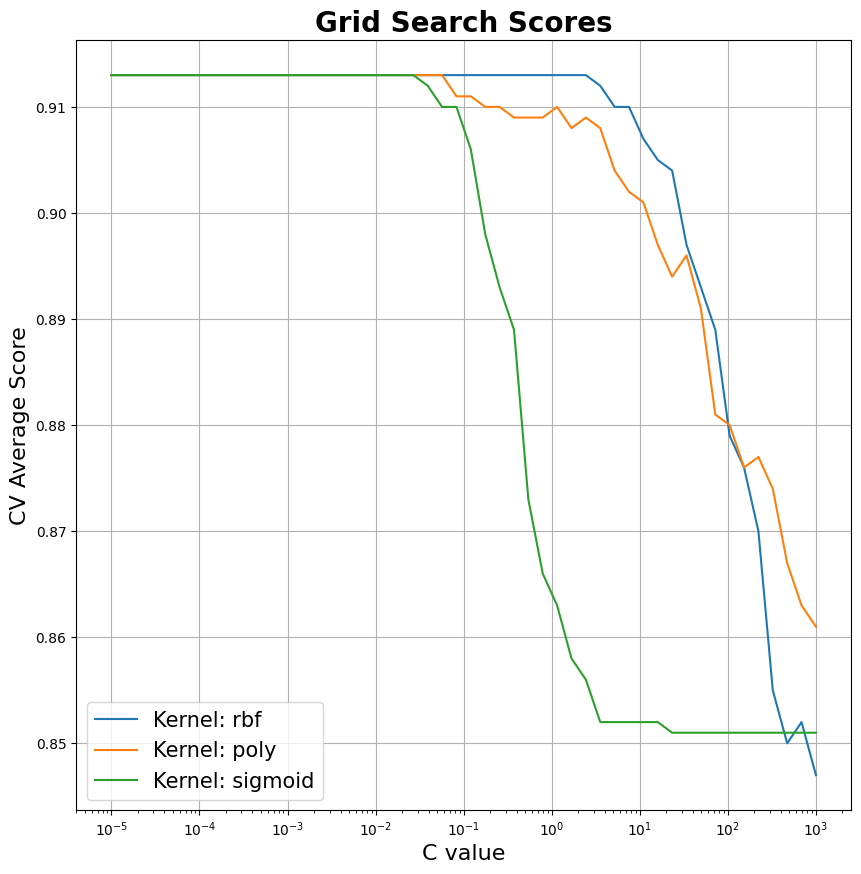

In [62]:
# Plot results from grid search and compare accuracy with the logistric regression model
# Get Test Scores Mean and std for each grid search
scores_mean = rf_grid.cv_results_['mean_test_score']
scores_mean = np.array(scores_mean).reshape(len(cVal),len(kernelType))

# Plot Grid search scores
_, ax = plt.subplots(1,1, figsize=(10,10))

# Param1 is the X-axis, Param 2 is represented as a different curve (color line)
for idx, val in enumerate(kernelType):
    ax.plot(cVal, scores_mean[:, idx], '-', label= 'Kernel: ' + str(val))

ax.set_xscale('log')
ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
ax.set_xlabel("C value", fontsize=16)
ax.set_ylabel('CV Average Score', fontsize=16)
ax.legend(loc="best", fontsize=15)
ax.grid('on')

modelOpt = rf_grid.best_estimator_
modelOpt = modelOpt.fit(X_train, y_train)
y_est_test = modelOpt.predict(X_test)
acc_svm = np.abs(sum(y_est_test == y_test))/len(y_test)
print("Logistic Regression accuracy of %0.2f, and svm accuracy of %0.2f" % (LogModelAcc, acc_svm))